### Import packages

In [1]:
import sys
sys.path.insert(0,'../..')
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
import time
import math
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchattacks
import torchvision
from tqdm.auto import tqdm, trange
from torchvision import transforms
from torchattacks.attack import Attack
from torchattacks.attacks._differential_evolution import differential_evolution

### Import biotorch classes and functions

In [2]:
from biotorch.datasets.cifar import CIFAR10Benchmark
from biotorch.applications.adversarial_attacks.visualization import imshow, plot_accuracy
from biotorch.applications.adversarial_attacks.functions import add_data_normalization, apply_attack_on_dataset, apply_attack_on_batch 

In [3]:
dataset = CIFAR10Benchmark(32, test_transforms=[
    transforms.transforms.Resize((32, 32)),
    transforms.ToTensor()])

cifar_mean = (0.4914, 0.4821, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

train_dataloader = dataset.create_train_dataloader(128)
val_dataloader = dataset.create_val_dataloader(128)
test_dataloader = dataset.create_test_dataloader(100)

Preparing CIFAR-10 Benchmark Dataset and storing data in ./datasets/cifar10
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Define the models

In [4]:
trained_models_directory = '../trained_models/CIFAR10/resnet-20'

bp_model_path   = os.path.join(trained_models_directory, 'bp/model_best_acc.pth')
fa_model_path   = os.path.join(trained_models_directory, 'fa/model_best_acc.pth')
dfa_model_path  = os.path.join(trained_models_directory, 'dfa/model_best_acc.pth')
sign_usf_model_path = os.path.join(trained_models_directory, 'sign_usf/model_best_acc.pth')
sign_frsf_model_path = os.path.join(trained_models_directory, 'sign_frsf/model_best_acc.pth')
sign_brsf_model_path = os.path.join(trained_models_directory, 'sign_brsf/model_best_acc.pth')

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model_bp = torch.load(bp_model_path, map_location='cuda:0')
model_bp = add_data_normalization(model_bp, cifar_mean, cifar_std).eval()
model_bp = model_bp.to(device)

model_fa = torch.load(fa_model_path, map_location='cuda:0')
model_fa = add_data_normalization(model_fa, cifar_mean, cifar_std).eval()
model_fa = model_fa.to(device)

model_dfa = torch.load(dfa_model_path, map_location='cuda:0')
model_dfa = add_data_normalization(model_dfa, cifar_mean, cifar_std).eval()
model_dfa = model_dfa.to(device)

model_sign_usf = torch.load(sign_usf_model_path, map_location='cuda:0')
model_sign_usf = add_data_normalization(model_sign_usf, cifar_mean, cifar_std).eval()
model_sign_usf = model_sign_usf.to(device)

model_sign_frsf = torch.load(sign_frsf_model_path, map_location='cuda:0')
model_sign_frsf = add_data_normalization(model_sign_frsf, cifar_mean, cifar_std).eval()
model_sign_frsf = model_sign_frsf.to(device)

model_sign_brsf = torch.load(sign_brsf_model_path, map_location='cuda:0')
model_sign_brsf = add_data_normalization(model_sign_brsf, cifar_mean, cifar_std).eval()
model_sign_brsf = model_sign_brsf.to(device)

In [6]:
class Square(Attack):
    r"""
    Square Attack in the paper 'Square Attack: a query-efficient black-box adversarial attack via random search'
    [https://arxiv.org/abs/1912.00049]
    [https://github.com/fra31/auto-attack]
    Distance Measure : Linf, L2
    Arguments:
        model (nn.Module): model to attack.
        norm (str): Lp-norm of the attack. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: None)
        n_queries (int): max number of queries (each restart). (Default: 5000)
        n_restarts (int): number of random restarts. (Default: 1)
        p_init (float): parameter to control size of squares. (Default: 0.8)
        loss (str): loss function optimized ['margin', 'ce'] (Default: 'margin')
        resc_schedule (bool): adapt schedule of p to n_queries (Default: True)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)
        targeted (bool): targeted. (Default: False)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.Square(model, model, norm='Linf', n_queries=5000, n_restarts=1, eps=None, p_init=.8, seed=0, verbose=False, targeted=False, loss='margin', resc_schedule=True)
        >>> adv_images = attack(images, labels)
    """
    def __init__(self, model, norm='Linf', eps=None, n_queries=50, n_restarts=1,
                 p_init=.8, loss='margin', resc_schedule=True,
                 seed=0, verbose=False):
        super().__init__("Square", model)
        self.norm = norm
        self.n_queries = n_queries
        self.eps = eps
        self.p_init = p_init
        self.n_restarts = n_restarts
        self.seed = seed
        self.verbose = verbose
        self.loss = loss
        self.rescale_schedule = resc_schedule
        self._supported_mode = ['default', 'targeted']

    def forward(self, images, labels):
        r"""
        Overridden.
        """
        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self.perturb(images, labels)

        return adv_images

    def margin_and_loss(self, x, y):
        """
        :param y:        correct labels if untargeted else target labels
        """

        logits = self.model(x)
        xent = F.cross_entropy(logits, y, reduction='none')
        u = torch.arange(x.shape[0])
        y_corr = logits[u, y].clone()
        logits[u, y] = -float('inf')
        y_others = logits.max(dim=-1)[0]

        if not self._targeted:
            if self.loss == 'ce':
                return y_corr - y_others, -1. * xent
            elif self.loss == 'margin':
                return y_corr - y_others, y_corr - y_others
        else:
            if self.loss == 'ce':
                return y_others - y_corr, xent
            elif self.loss == 'margin':
                return y_others - y_corr, y_others - y_corr

    def init_hyperparam(self, x):
        assert self.norm in ['Linf', 'L2']
        assert not self.eps is None
        assert self.loss in ['ce', 'margin']

        if self.device is None:
            self.device = x.device
        self.orig_dim = list(x.shape[1:])
        self.ndims = len(self.orig_dim)
        if self.seed is None:
            self.seed = time.time()

    def check_shape(self, x):
        return x if len(x.shape) == (self.ndims + 1) else x.unsqueeze(0)

    def random_choice(self, shape):
        t = 2 * torch.rand(shape).to(self.device) - 1
        return torch.sign(t)

    def random_int(self, low=0, high=1, shape=[1]):
        t = low + (high - low) * torch.rand(shape).to(self.device)
        return t.long()

    def normalize(self, x):
        if self.norm == 'Linf':
            t = x.abs().view(x.shape[0], -1).max(1)[0]
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

        elif self.norm == 'L2':
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return x / (t.view(-1, *([1] * self.ndims)) + 1e-12)

    def lp_norm(self, x):
        if self.norm == 'L2':
            t = (x ** 2).view(x.shape[0], -1).sum(-1).sqrt()
            return t.view(-1, *([1] * self.ndims))

    def eta_rectangles(self, x, y):
        delta = torch.zeros([x, y]).to(self.device)
        x_c, y_c = x // 2 + 1, y // 2 + 1

        counter2 = [x_c - 1, y_c - 1]
        for counter in range(0, max(x_c, y_c)):
          delta[max(counter2[0], 0):min(counter2[0] + (2*counter + 1), x),
              max(0, counter2[1]):min(counter2[1] + (2*counter + 1), y)
              ] += 1.0/(torch.Tensor([counter + 1]).view(1, 1).to(
              self.device) ** 2)
          counter2[0] -= 1
          counter2[1] -= 1

        delta /= (delta ** 2).sum(dim=(0,1), keepdim=True).sqrt()
    
        return delta

    def eta(self, s):
        delta = torch.zeros([s, s]).to(self.device)
        delta[:s // 2] = self.eta_rectangles(s // 2, s)
        delta[s // 2:] = -1. * self.eta_rectangles(s - s // 2, s)
        delta /= (delta ** 2).sum(dim=(0, 1), keepdim=True).sqrt()
        if torch.rand([1]) > 0.5:
            delta = delta.permute([1, 0])

        return delta

    def p_selection(self, it):
        """ schedule to decrease the parameter p """

        if self.rescale_schedule:
            it = int(it / self.n_queries * 10000)

        if 10 < it <= 50:
            p = self.p_init / 2
        elif 50 < it <= 200:
            p = self.p_init / 4
        elif 200 < it <= 500:
            p = self.p_init / 8
        elif 500 < it <= 1000:
            p = self.p_init / 16
        elif 1000 < it <= 2000:
            p = self.p_init / 32
        elif 2000 < it <= 4000:
            p = self.p_init / 64
        elif 4000 < it <= 6000:
            p = self.p_init / 128
        elif 6000 < it <= 8000:
            p = self.p_init / 256
        elif 8000 < it:
            p = self.p_init / 512
        else:
            p = self.p_init

        return p

    def attack_single_run(self, x, y):
        with torch.no_grad():
            adv = x.clone()
            c, h, w = x.shape[1:]
            n_features = c * h * w
            n_ex_total = x.shape[0]
            
            if self.norm == 'Linf':
                x_best = torch.clamp(x + self.eps * self.random_choice(
                    [x.shape[0], c, 1, w]), 0., 1.)
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))
                
                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()
                    
                    if len(idx_to_fool) == 0:
                        break
                        
                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]
                    
                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 1)
                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas = torch.zeros([c, h, w]).to(self.device)
                    new_deltas[:, vh:vh + s, vw:vw + s
                        ] = 2. * self.eps * self.random_choice([c, 1, 1])
                    
                    x_new = x_best_curr + new_deltas
                    x_new = torch.min(torch.max(x_new, x_curr - self.eps),
                        x_curr + self.eps)
                    x_new = torch.clamp(x_new, 0., 1.)
                    x_new = self.check_shape(x_new)
                    
                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = idx_improved * loss + (
                        1. - idx_improved) * loss_min_curr

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = idx_improved * margin + (
                        1. - idx_improved) * margin_min_curr
                    idx_improved = idx_improved.reshape([-1,
                        *[1]*len(x.shape[:-1])])
                    x_best[idx_to_fool] = idx_improved * x_new + (
                        1. - idx_improved) * x_best_curr
                    n_queries[idx_to_fool] += 1.

                    ind_succ = (margin_min <= 0.).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print('{}'.format(i_iter + 1),
                            '- success rate={}/{} ({:.2%})'.format(
                            ind_succ.numel(), n_ex_total,
                            float(ind_succ.numel()) / n_ex_total),
                            '- avg # queries={:.1f}'.format(
                            n_queries[ind_succ].mean().item()),
                            '- med # queries={:.1f}'.format(
                            n_queries[ind_succ].median().item()),
                            '- loss={:.3f}'.format(loss_min.mean()))

                    if ind_succ.numel() == n_ex_total:
                        break
              
            elif self.norm == 'L2':
                delta_init = torch.zeros_like(x)
                s = h // 5
                sp_init = (h - s * 5) // 2
                vh = sp_init + 0
                for _ in range(h // s):
                    vw = sp_init + 0
                    for _ in range(w // s):
                        delta_init[:, :, vh:vh + s, vw:vw + s] += self.eta(
                            s).view(1, 1, s, s) * self.random_choice(
                            [x.shape[0], c, 1, 1])
                        vw += s
                    vh += s

                x_best = torch.clamp(x + self.normalize(delta_init
                    ) * self.eps, 0., 1.)
                margin_min, loss_min = self.margin_and_loss(x_best, y)
                n_queries = torch.ones(x.shape[0]).to(self.device)
                s_init = int(math.sqrt(self.p_init * n_features / c))

                for i_iter in range(self.n_queries):
                    idx_to_fool = (margin_min > 0.0).nonzero().flatten()

                    if len(idx_to_fool) == 0:
                        break
                        
                    x_curr = self.check_shape(x[idx_to_fool])
                    x_best_curr = self.check_shape(x_best[idx_to_fool])
                    y_curr = y[idx_to_fool]
                    if len(y_curr.shape) == 0:
                        y_curr = y_curr.unsqueeze(0)
                    margin_min_curr = margin_min[idx_to_fool]
                    loss_min_curr = loss_min[idx_to_fool]

                    delta_curr = x_best_curr - x_curr
                    p = self.p_selection(i_iter)
                    s = max(int(round(math.sqrt(p * n_features / c))), 3)
                    if s % 2 == 0:
                        s += 1

                    vh = self.random_int(0, h - s)
                    vw = self.random_int(0, w - s)
                    new_deltas_mask = torch.zeros_like(x_curr)
                    new_deltas_mask[:, :, vh:vh + s, vw:vw + s] = 1.0
                    norms_window_1 = (delta_curr[:, :, vh:vh + s, vw:vw + s
                        ] ** 2).sum(dim=(-2, -1), keepdim=True).sqrt()

                    vh2 = self.random_int(0, h - s)
                    vw2 = self.random_int(0, w - s)
                    new_deltas_mask_2 = torch.zeros_like(x_curr)
                    new_deltas_mask_2[:, :, vh2:vh2 + s, vw2:vw2 + s] = 1.

                    norms_image = self.lp_norm(x_best_curr - x_curr)
                    mask_image = torch.max(new_deltas_mask, new_deltas_mask_2)
                    norms_windows = self.lp_norm(delta_curr * mask_image)

                    new_deltas = torch.ones([x_curr.shape[0], c, s, s]
                        ).to(self.device)
                    new_deltas *= (self.eta(s).view(1, 1, s, s) *
                        self.random_choice([x_curr.shape[0], c, 1, 1]))
                    old_deltas = delta_curr[:, :, vh:vh + s, vw:vw + s] / (
                        1e-12 + norms_window_1)
                    new_deltas += old_deltas
                    new_deltas = new_deltas / (1e-12 + (new_deltas ** 2).sum(
                        dim=(-2, -1), keepdim=True).sqrt()) * (torch.max(
                        (self.eps * torch.ones_like(new_deltas)) ** 2 -
                        norms_image ** 2, torch.zeros_like(new_deltas)) /
                        c + norms_windows ** 2).sqrt()
                    delta_curr[:, :, vh2:vh2 + s, vw2:vw2 + s] = 0.
                    delta_curr[:, :, vh:vh + s, vw:vw + s] = new_deltas + 0

                    x_new = torch.clamp(x_curr + self.normalize(delta_curr
                        ) * self.eps, 0. ,1.)
                    x_new = self.check_shape(x_new)
                    norms_image = self.lp_norm(x_new - x_curr)

                    margin, loss = self.margin_and_loss(x_new, y_curr)

                    # update loss if new loss is better
                    idx_improved = (loss < loss_min_curr).float()

                    loss_min[idx_to_fool] = idx_improved * loss + (
                        1. - idx_improved) * loss_min_curr

                    # update margin and x_best if new loss is better
                    # or misclassification
                    idx_miscl = (margin <= 0.).float()
                    idx_improved = torch.max(idx_improved, idx_miscl)

                    margin_min[idx_to_fool] = idx_improved * margin + (
                        1. - idx_improved) * margin_min_curr
                    idx_improved = idx_improved.reshape([-1,
                        *[1]*len(x.shape[:-1])])
                    x_best[idx_to_fool] = idx_improved * x_new + (
                        1. - idx_improved) * x_best_curr
                    n_queries[idx_to_fool] += 1.

                    ind_succ = (margin_min <= 0.).nonzero().squeeze()
                    if self.verbose and ind_succ.numel() != 0:
                        print('{}'.format(i_iter + 1),
                            '- success rate={}/{} ({:.2%})'.format(
                            ind_succ.numel(), n_ex_total, float(
                            ind_succ.numel()) / n_ex_total),
                            '- avg # queries={:.1f}'.format(
                            n_queries[ind_succ].mean().item()),
                            '- med # queries={:.1f}'.format(
                            n_queries[ind_succ].median().item()),
                            '- loss={:.3f}'.format(loss_min.mean()))

                    assert (x_new != x_new).sum() == 0
                    assert (x_best != x_best).sum() == 0
                    
                    if ind_succ.numel() == n_ex_total:
                        break

        return n_queries, x_best

    def perturb(self, x, y=None):
        """
        :param x:           clean images
        :param y:           untargeted attack -> clean labels,
                            if None we use the predicted labels
                            targeted attack -> target labels, if None random classes,
                            different from the predicted ones, are sampled
        """

        self.init_hyperparam(x)

        adv = x.clone()
        if y is None:
            if not self._targeted:
                with torch.no_grad():
                    output = self.model(x)
                    y_pred = output.max(1)[1]
                    y = y_pred.detach().clone().long().to(self.device)
            else:
                with torch.no_grad():
                    y = self._get_target_label(x, None)
        else:
            if not self._targeted:
                y = y.detach().clone().long().to(self.device)
            else:
                y = self._get_target_label(x, y)

        if not self._targeted:
            acc = self.model(x).max(1)[1] == y
        else:
            acc = self.model(x).max(1)[1] != y

        startt = time.time()

        torch.random.manual_seed(self.seed)
        torch.cuda.random.manual_seed(self.seed)

        for counter in range(self.n_restarts):
            ind_to_fool = acc.nonzero().squeeze()
            if len(ind_to_fool.shape) == 0:
                ind_to_fool = ind_to_fool.unsqueeze(0)
            if ind_to_fool.numel() != 0:
                x_to_fool = x[ind_to_fool].clone()
                y_to_fool = y[ind_to_fool].clone()

                _, adv_curr = self.attack_single_run(x_to_fool, y_to_fool)

                output_curr = self.model(adv_curr)
                if not self._targeted:
                    acc_curr = output_curr.max(1)[1] == y_to_fool
                else:
                    acc_curr = output_curr.max(1)[1] != y_to_fool
                ind_curr = (acc_curr == 0).nonzero().squeeze()

                acc[ind_to_fool[ind_curr]] = 0
                adv[ind_to_fool[ind_curr]] = adv_curr[ind_curr].clone()
                if self.verbose:
                    print('restart {} - robust accuracy: {:.2%}'.format(
                        counter, acc.float().mean()),
                        '- cum. time: {:.1f} s'.format(
                        time.time() - startt))

        return adv

In [7]:
def apply_attack_on_limited_dataset(model, dataloader, attack, device, verbose=True, n=1):
    robust_accuracy = []
    c_a = []
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        c_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())

    clean_accuracy = np.mean(c_a)
    print('Clean accuracy: ', clean_accuracy)

    r_a = []
    if verbose:
        t = trange(len(dataloader))
    for k, (images, labels) in enumerate(dataloader):
        if k >= n:
            break
        images, labels = images.to(device), labels.to(device)
        adv_images = attack(images, labels)
        outputs = model(adv_images)
        _, pre = torch.max(outputs.data, 1)
        correct_predictions = pre == labels
        r_a.append((correct_predictions.sum() / len(correct_predictions)).cpu().numpy())
        if verbose:
            t.update(1)

    robust_acc = np.mean(r_a)
    if verbose:
        print('Robust accuracy: ', robust_acc)
    robust_accuracy.append(robust_acc)

    return clean_accuracy, robust_accuracy

### Run the Square attack

In [8]:
epsilons = np.linspace(0., 0.1, num=30)

In [9]:
clean_accuracy_bp_list, robust_accuracy_bp_list = [], []
for eps in epsilons:
    attack_bp = Square(model_bp, eps=eps)
    clean_accuracy_bp, robust_accuracy_bp = \
            apply_attack_on_limited_dataset(model_bp, test_dataloader, attack_bp, device, verbose=True, n=5)
    clean_accuracy_bp_list.append(clean_accuracy_bp)
    robust_accuracy_bp_list.append(robust_accuracy_bp)

Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.91999996
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.89399993
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.8679999
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.822
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.77199996
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.712
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.64799994
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.586
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.516
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.464
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.396
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.37
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.302
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.26
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.23199996
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.198
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.172
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.154
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.122
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.102
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.088
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.077999994
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.062
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.058
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.047999997
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.044
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.037999995
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.033999998
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.029999997
Clean accuracy:  0.91999996


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.025999999


In [10]:
clean_accuracy_fa_list, robust_accuracy_fa_list = [], []
for eps in epsilons:
    attack_fa = Square(model_fa, eps=eps)
    clean_accuracy_fa, robust_accuracy_fa = \
            apply_attack_on_limited_dataset(model_fa, test_dataloader, attack_fa, device, verbose=True, n=5)
    clean_accuracy_fa_list.append(clean_accuracy_fa)
    robust_accuracy_fa_list.append(robust_accuracy_fa)

Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.658
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.616
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.584
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.54999995
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.51199996
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.47400004
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.42600003
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.39200002
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.34600002
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.324
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.28399998
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.25599998
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.234
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.20199999
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.16199999
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.15
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.12799999
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.114
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.102
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.089999996
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.08
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.07
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.063999996
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.058
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.051999997
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.043999996
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.042
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.036000002
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.038
Clean accuracy:  0.658


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.029999997


In [11]:
clean_accuracy_dfa_list, robust_accuracy_dfa_list = [], []
for eps in epsilons:
    attack_dfa = Square(model_dfa, eps=eps)
    clean_accuracy_dfa, robust_accuracy_dfa = \
            apply_attack_on_limited_dataset(model_dfa, test_dataloader, attack_dfa, device, verbose=True, n=5)
    clean_accuracy_dfa_list.append(clean_accuracy_dfa)
    robust_accuracy_dfa_list.append(robust_accuracy_dfa)

Clean accuracy:  0.542


/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.542
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.51
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.464
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.43599996
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.37399998
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.32599998
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.27199998
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.25599998
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.21799998
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.19999997
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.182
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.15599999
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.128
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.11799999
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.112
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.094
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.088
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.07399999
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.07
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.059999995
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.052000005
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.054
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.046
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.04
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.042
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.036
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.037999995
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.036
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.034
Clean accuracy:  0.542


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.030000001


In [12]:
clean_accuracy_sign_usf_list, robust_accuracy_sign_usf_list = [], []
for eps in epsilons:
    attack_sign_usf = Square(model_sign_usf, eps=eps)
    clean_accuracy_sign_usf, robust_accuracy_sign_usf = \
            apply_attack_on_limited_dataset(model_sign_usf, test_dataloader, attack_sign_usf, device, verbose=True, n=5)
    clean_accuracy_sign_usf_list.append(clean_accuracy_sign_usf)
    robust_accuracy_sign_usf_list.append(robust_accuracy_sign_usf)

Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.916
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.8759999
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.844
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.80600005
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.764
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.73
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.67399997
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.59400004
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.534
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.452
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.40399998
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.366
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.326
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.28399998
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.226
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.19399998
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.18200001
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.16
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.14199999
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.120000005
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.116
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.102
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.092
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.076
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.062
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.062
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.053999998
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.048
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.031999998
Clean accuracy:  0.916


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.036000002


In [13]:
clean_accuracy_sign_frsf_list, robust_accuracy_sign_frsf_list = [], []
for eps in epsilons:
    attack_sign_frsf = Square(model_sign_frsf, eps=eps)
    clean_accuracy_sign_frsf, robust_accuracy_sign_frsf = \
            apply_attack_on_limited_dataset(model_sign_frsf, test_dataloader, attack_sign_frsf, device, verbose=True, n=5)
    clean_accuracy_sign_frsf_list.append(clean_accuracy_sign_frsf)
    robust_accuracy_sign_frsf_list.append(robust_accuracy_sign_frsf)

Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.89799994
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.87
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.83199996
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.8039999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.754
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.7
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.636
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.58
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.52
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.43999997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.38199997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.33999997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.32
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.278
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.232
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.19399999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.15599999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.13
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.108
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.089999996
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.07399999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.072
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.051999997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.042
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.042
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.029999997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.029999997
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.025999999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.014
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.022


In [14]:
clean_accuracy_sign_brsf_list, robust_accuracy_sign_brsf_list = [], []
for eps in epsilons:
    attack_sign_brsf = Square(model_sign_brsf, eps=eps)
    clean_accuracy_sign_brsf, robust_accuracy_sign_brsf = \
            apply_attack_on_limited_dataset(model_sign_brsf, test_dataloader, attack_sign_brsf, device, verbose=True, n=5)
    clean_accuracy_sign_brsf_list.append(clean_accuracy_sign_brsf)
    robust_accuracy_sign_brsf_list.append(robust_accuracy_sign_brsf)

Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.89799994
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.8679999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.82600003
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.79199994
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.752
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.712
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.66999996
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.60199994
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.548
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.466
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.408
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.37
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.332
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.302
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.264
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.228
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.19399999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.174
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.16
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.14199999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.121999994
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.103999995
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.094
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.08799999
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.084
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.074
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.067999996
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.056
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.048
Clean accuracy:  0.89799994


  0%|          | 0/100 [00:00<?, ?it/s]

Robust accuracy:  0.044


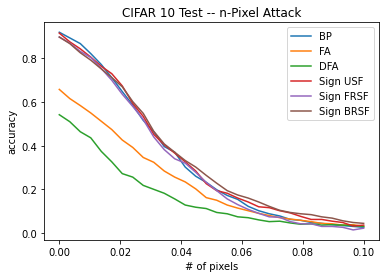

In [15]:
plot_accuracy(epsilons, 
              [
                  robust_accuracy_bp_list,
                  robust_accuracy_fa_list, 
                  robust_accuracy_dfa_list, 
                  robust_accuracy_sign_usf_list,
                  robust_accuracy_sign_frsf_list,
                  robust_accuracy_sign_brsf_list,
              ], 
              ['BP', 'FA', 'DFA', 'Sign USF', 'Sign FRSF', 'Sign BRSF'],
              'CIFAR 10 Test -- n-Pixel Attack',
              '# of pixels')

### Run the Square attack on a batch of the test set

In [17]:
images, labels = iter(test_dataloader).next()

In [18]:
adv_images_fa, success_fa, accuracy_clean_fa, accuracy_robust_fa = apply_attack_on_batch(model_fa, images, labels, attack_fa, device)
plot_images_fa = images[success_fa]
plot_images_adv_fa = adv_images_fa[success_fa]

Clean Accuracy on Batch: 0.73%
Robust Accuracy on Batch: 0.02%


In [19]:
adv_images_bp, success_bp, accuracy_clean_bp, accuracy_robust_bp = apply_attack_on_batch(model_bp, images, labels, attack_bp, device)
plot_images_bp = images[success_bp]
plot_images_adv_bp = adv_images_bp[success_bp]

Clean Accuracy on Batch: 0.93%
Robust Accuracy on Batch: 0.02%


In [20]:
adv_images_sign_usf, success_sign_usf, accuracy_clean_sign_usf, accuracy_robust_sign_usf = \
    apply_attack_on_batch(model_sign_usf, images, labels, attack_sign_usf, device)
plot_images_sign_usf = images[success_sign_usf]
plot_images_adv_sign_usf = adv_images_sign_usf[success_sign_usf]

Clean Accuracy on Batch: 0.93%
Robust Accuracy on Batch: 0.05%


In [21]:
adv_images_sign_brsf, success_sign_brsf, accuracy_clean_sign_brsf, accuracy_robust_sign_brsf = \
    apply_attack_on_batch(model_sign_brsf, images, labels, attack_sign_brsf, device)
plot_images_sign_brsf = images[success_sign_brsf]
plot_images_adv_sign_brsf = adv_images_sign_brsf[success_sign_brsf]

Clean Accuracy on Batch: 0.91%
Robust Accuracy on Batch: 0.05%


In [22]:
adv_images_sign_frsf, success_sign_frsf, accuracy_clean_sign_frsf, accuracy_robust_sign_frsf = \
    apply_attack_on_batch(model_sign_frsf, images, labels, attack_sign_frsf, device)
plot_images_sign_frsf = images[success_sign_frsf]
plot_images_adv_sign_frsf = adv_images_sign_frsf[success_sign_frsf]

Clean Accuracy on Batch: 0.9%
Robust Accuracy on Batch: 0.03%


In [23]:
adv_images_dfa, success_dfa, accuracy_clean_dfa, accuracy_robust_dfa = apply_attack_on_batch(model_dfa, images, labels, attack_dfa, device)
plot_images_dfa = images[success_dfa]
plot_images_adv_dfa = adv_images_dfa[success_dfa]

/home/mohamed/workspace/biotorch/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Clean Accuracy on Batch: 0.56%
Robust Accuracy on Batch: 0.03%


### Plot the adversarial images

#### BP

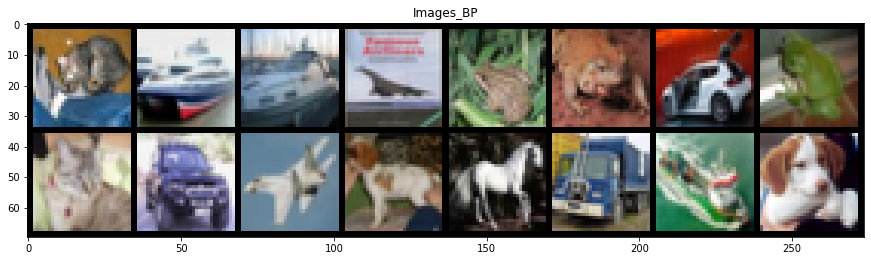

In [24]:
imshow(torchvision.utils.make_grid(plot_images_bp[0:16], normalize=False), "Images_BP")

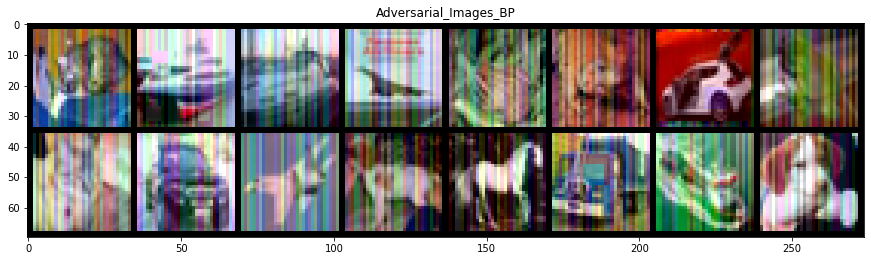

In [25]:
imshow(torchvision.utils.make_grid(plot_images_adv_bp[0:16], normalize=False), "Adversarial_Images_BP")

#### FA

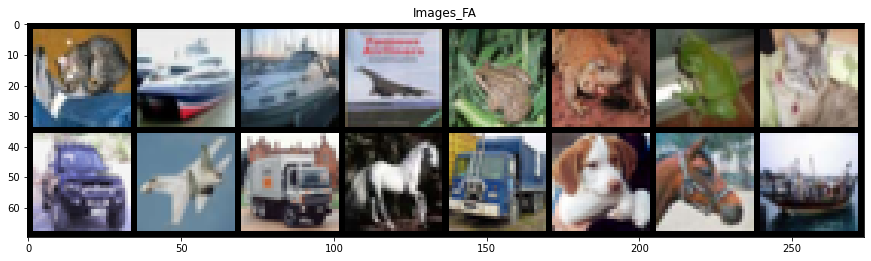

In [26]:
imshow(torchvision.utils.make_grid(plot_images_fa[0:16], normalize=False), "Images_FA")

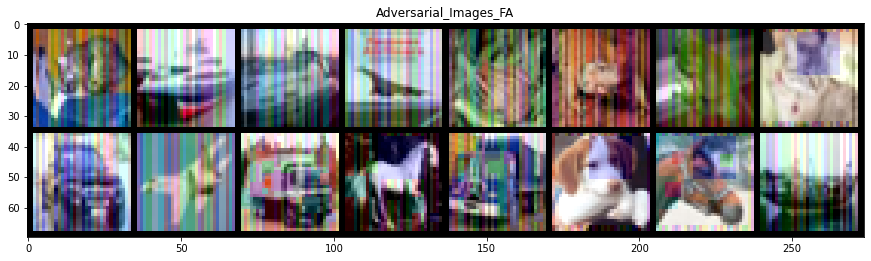

In [27]:
imshow(torchvision.utils.make_grid(plot_images_adv_fa[0:16], normalize=False), "Adversarial_Images_FA")

#### DFA

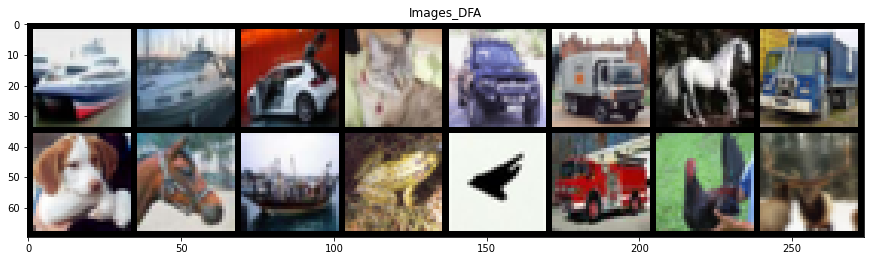

In [28]:
imshow(torchvision.utils.make_grid(plot_images_dfa[0:16], normalize=False), "Images_DFA")

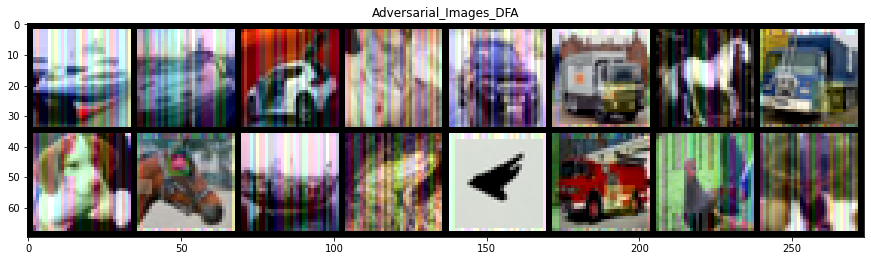

In [29]:
imshow(torchvision.utils.make_grid(plot_images_adv_dfa[0:16], normalize=False), "Adversarial_Images_DFA")

#### Sign USF

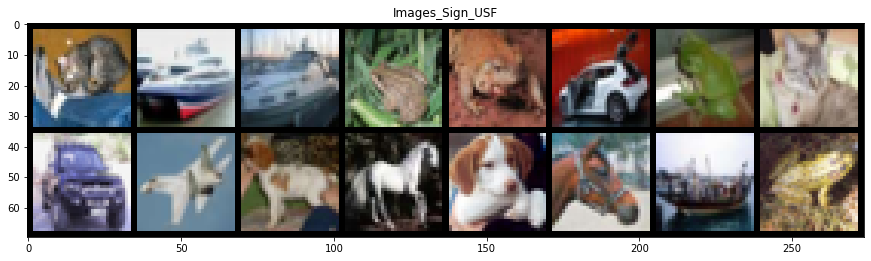

In [30]:
imshow(torchvision.utils.make_grid(plot_images_sign_usf[0:16], normalize=False), "Images_Sign_USF")

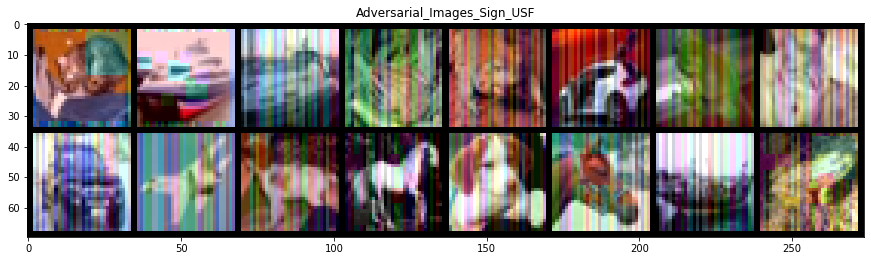

In [31]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_usf[0:16], normalize=False), "Adversarial_Images_Sign_USF")

#### Sign BRSF

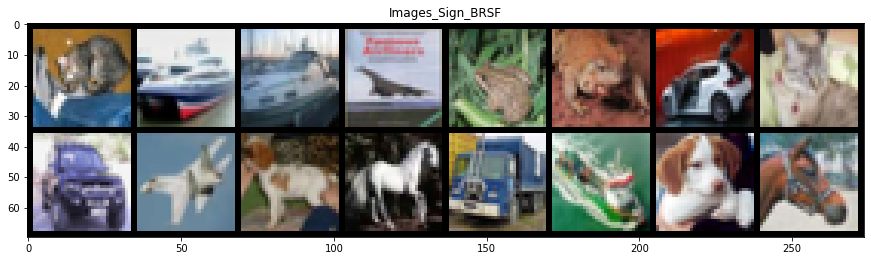

In [32]:
imshow(torchvision.utils.make_grid(plot_images_sign_brsf[0:16], normalize=False), "Images_Sign_BRSF")

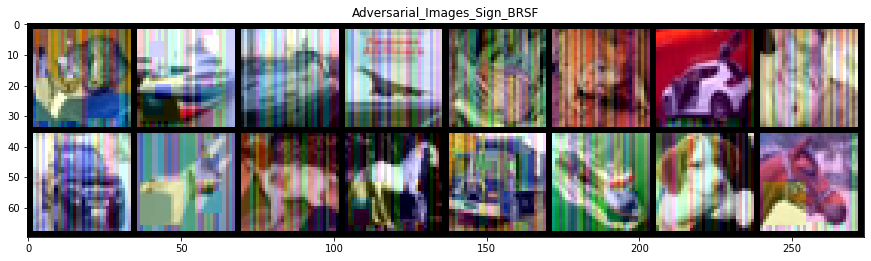

In [33]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_brsf[0:16], normalize=False), "Adversarial_Images_Sign_BRSF")

#### Sign FRSF

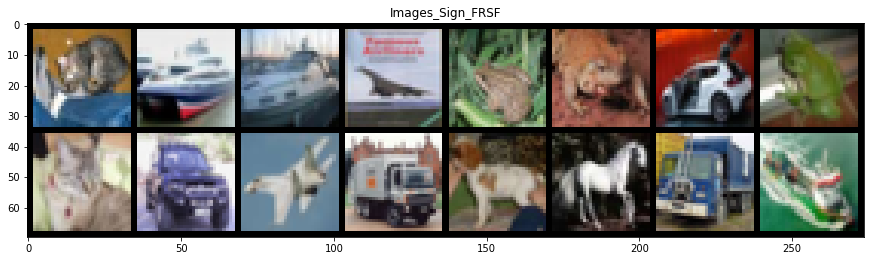

In [34]:
imshow(torchvision.utils.make_grid(plot_images_sign_frsf[0:16], normalize=False), "Images_Sign_FRSF")

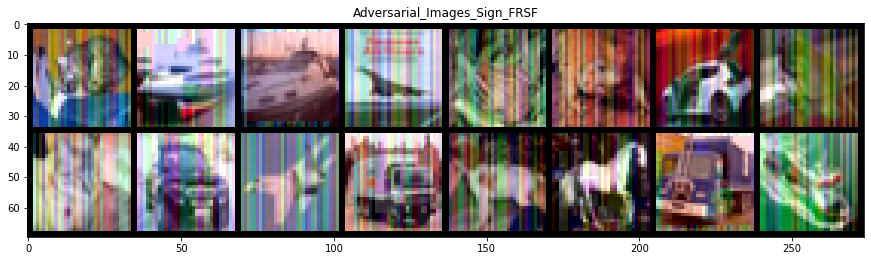

In [35]:
imshow(torchvision.utils.make_grid(plot_images_adv_sign_frsf[0:16], normalize=False), "Adversarial_Images_Sign_FRSF")